# Read the png Files

In [1]:
import matplotlib.pyplot as plt
import cv2 
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
def read_dataset(lispath, target, resize_shape=(256, 256)):
    imgs = []
    for file in os.listdir(lispath):
        if file[-3:] == 'png':
            img = cv2.imread(os.path.join(lispath, file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, resize_shape)  # Resize image to 256x256 or any desired size
            imgs.append(np.array(img))

    labels = len(imgs) * [target]
    return np.array(imgs), np.array(labels)


In [3]:
type3, labels3 = read_dataset('Type III radio burst 2022', 'Type III',resize_shape=(2066,1067))
print(np.shape(type3))


(262, 1067, 2066, 3)


In [4]:
type2, labels2 = read_dataset('Type II radio burst 2022', 'Type II',resize_shape=(2066,1067))
print(np.shape(type2))


(42, 1067, 2066, 3)


In [5]:
images = np.concatenate([type3,type2])
labels = np.concatenate([labels3,labels2])

In [6]:
images.shape

(304, 1067, 2066, 3)

In [7]:
labels.shape

(304,)

# Read the FITS files

In [8]:
import numpy as np
from astropy.io import fits

def read_fits(filename):
    """
    General function to read a FITS dataset, extract the data matrix, 
    frequency axis, and time axis.

    Parameters:
    filename (str): Path to the FITS file.

    Returns:
    data_matrix (np.ndarray): The 2D data array.
    freqs (np.ndarray): Frequency axis (1D array).
    time (np.ndarray): Time axis (1D array).
    """
    try:
        # Open the FITS file
        with fits.open(filename) as hdul:
            # Extract data matrix from primary HDU
            data_matrix = hdul[0].data
            
            # Extract binary table data from HDU 1 if it exists
            if len(hdul) > 1 and isinstance(hdul[1], fits.BinTableHDU):
                binary_table = hdul[1].data

                # Extract frequency and time axes
                freqs = binary_table['FREQUENCY'][0]  # First row contains all frequency points
                time = binary_table['TIME'][0]  # First row contains all time points
            else:
                raise ValueError("Binary table not found or invalid structure.")

            # Check if data matrix dimensions match the axes (after swapping axes)
            if data_matrix.shape[0] != len(freqs) or data_matrix.shape[1] != len(time):
                raise ValueError("Data matrix dimensions do not match frequency and time axes.")
            
            return data_matrix, freqs, time

    except Exception as e:
        # Handle exceptions silently
        return None, None, None


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fits_data(data_matrix, freqs, time, title_raw='Raw Spectrum', title_filtered='Filtered Spectrum', vmin=None, vmax=None):
    """
    Function to plot both the raw and filtered data matrices with frequency and time axes.

    Parameters:
    data_matrix (np.ndarray): The 2D data array to plot.
    freqs (np.ndarray): Frequency axis (1D array).
    time (np.ndarray): Time axis (1D array).
    title_raw (str): Title for the raw spectrum plot.
    title_filtered (str): Title for the filtered spectrum plot.
    vmin (float): Minimum value for color scaling (optional).
    vmax (float): Maximum value for color scaling (optional).
    """
    # Plot the raw spectrum
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)  # Create a subplot for side-by-side plots
    plt.imshow(data_matrix, aspect='auto', extent=[time[0], time[-1], freqs[0], freqs[-1]], origin='lower')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (MHz)')
    plt.colorbar()
    plt.title(title_raw)
    
    # Optional: Adjust color scaling for better visualization of raw data
    if vmin is not None and vmax is not None:
        plt.clim(vmin, vmax)
    
    # Compute background as the mean along the time axis
    background = np.mean(data_matrix, axis=1)  # Mean across time axis (for each frequency band)
    background = np.tile(background, (data_matrix.shape[1], 1)).T  # Expand to match data_matrix size

    # Subtract background to get filtered data
    filtered_data = data_matrix - background
    
    # Clip the filtered data to a certain range (optional)
    filtered_data = np.clip(filtered_data, -1, 25)  # Adjust clipping range as needed

    # Plot the filtered spectrum
    plt.subplot(1, 2, 2)  # Second plot for the filtered spectrum
    plt.imshow(filtered_data, aspect='auto', extent=[time[0], time[-1], freqs[0], freqs[-1]], origin='lower')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (MHz)')
    plt.colorbar()
    plt.title(title_filtered)

    # Optional: Adjust color scaling for better visualization of filtered data
    if vmin is not None and vmax is not None:
        minValue = np.min(filtered_data)
        maxValue = np.max(filtered_data)
        plt.clim(minValue, maxValue)

    # Show both plots
    plt.tight_layout()
    plt.show()



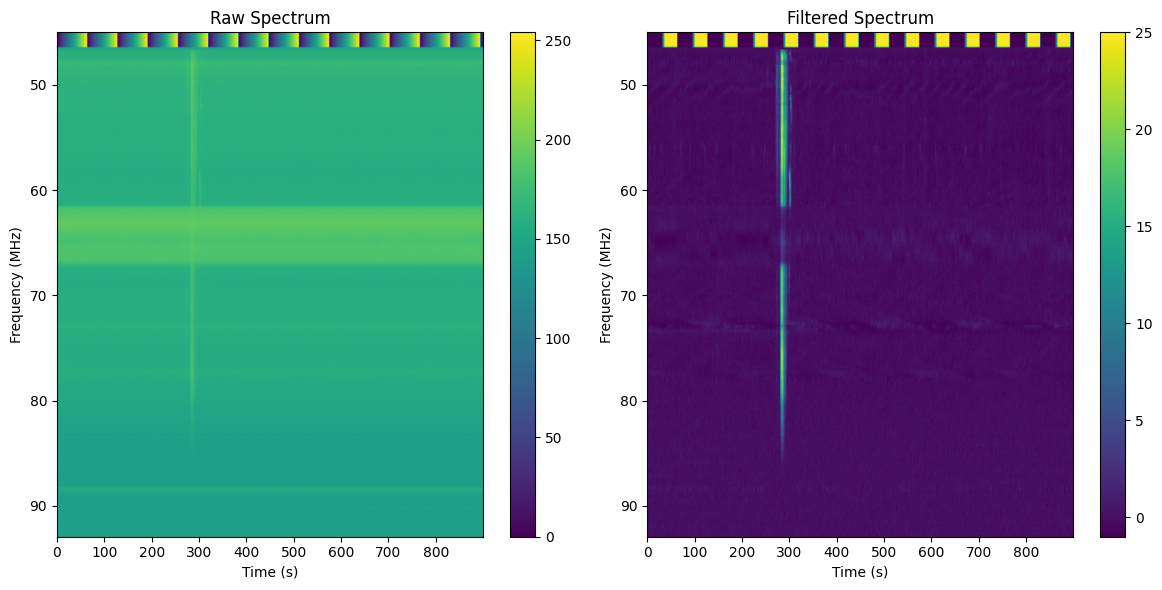

In [10]:
# Example usage:
filename = 'ALASKA-COHOE_20220108_230000_01.fit\c_\CALLISTO-01\FITfiles\ALASKA-COHOE_20220108_230000_01.fit'
data_matrix, freqs, time = read_fits(filename)

if data_matrix is not None:
    plot_fits_data(data_matrix, freqs, time)

In [11]:
def read_fits_dataset(path):
    images = []
    labels = []
    times = []
    freqs = []
    first_image_shape = None  # Variable to hold the shape of the first image
    
    for file in tqdm(os.listdir(path)):
        if file.endswith("gz"):  # Ensuring we're reading only the .gz files
            img, freq, time = read_fits(os.path.join(path, file))
            
            if img is not None:
                if first_image_shape is None:  # Set the shape of the first image
                    first_image_shape = img.shape
                    
                # Resize all subsequent images to match the first image's shape
                img_resized = cv2.resize(img, (first_image_shape[1], first_image_shape[0]))
                
                images.append(img_resized)
                labels.append(path[:path.index('r') - 1])  # Extract label based on path
                freqs.append(freq)
                times.append(time)
    
    return images, pd.DataFrame({'freqs': freqs, 'times': times, 'labels': labels})

In [12]:
dataset2, info2= read_fits_dataset('Type II radio burst 2022')
np.shape(dataset2)

100%|██████████| 90/90 [00:01<00:00, 48.75it/s]


(48, 200, 3600)

In [13]:
info2

,freqs,times,labels
0,"[164.5, 164.25, 163.5, 162.75, 162.375, 161.31...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",Type II
1,"[164.5, 164.25, 163.5, 162.75, 162.375, 161.31...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",Type II
2,"[868.06298828125, 865.625, 860.81298828125, 85...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",Type II
3,"[164.5, 164.25, 163.5, 162.75, 162.375, 161.31...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",Type II
4,"[164.5, 164.25, 163.5, 162.75, 162.375, 161.31...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",Type II
5,"[868.06298828125, 865.625, 860.81298828125, 85...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",Type II
6,"[86.625, 86.25, 85.875, 85.81300354003906, 85....","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",Type II
7,"[86.93800354003906, 86.56300354003906, 86.1880...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",Type II
8,"[86.93800354003906, 86.56300354003906, 86.1880...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",Type II
9,"[86.93800354003906, 86.56300354003906, 86.1880...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",Type II


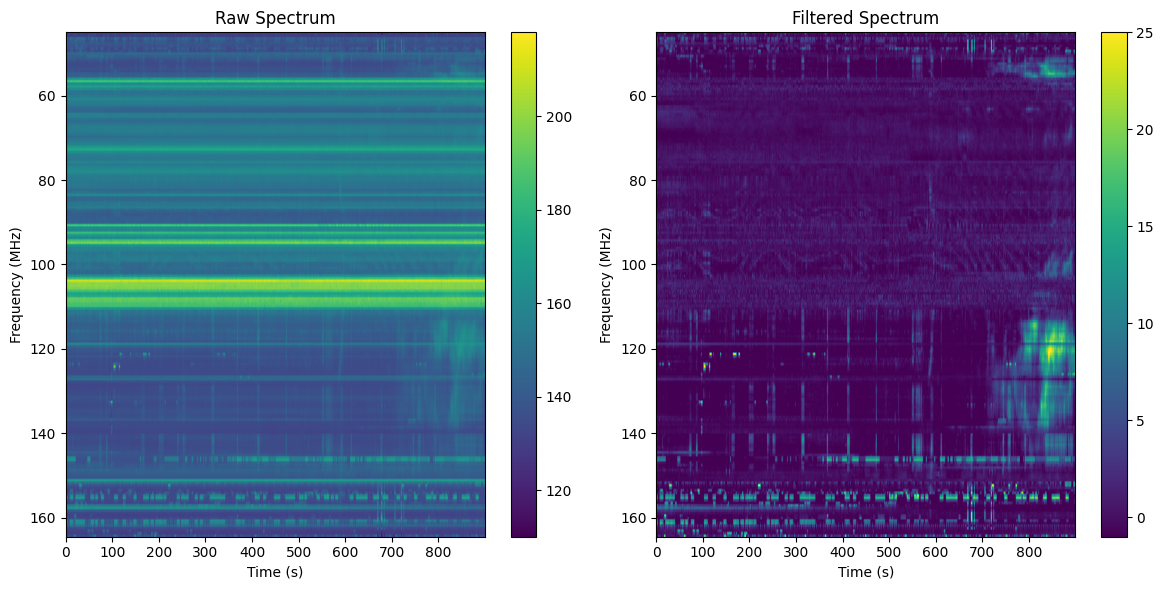

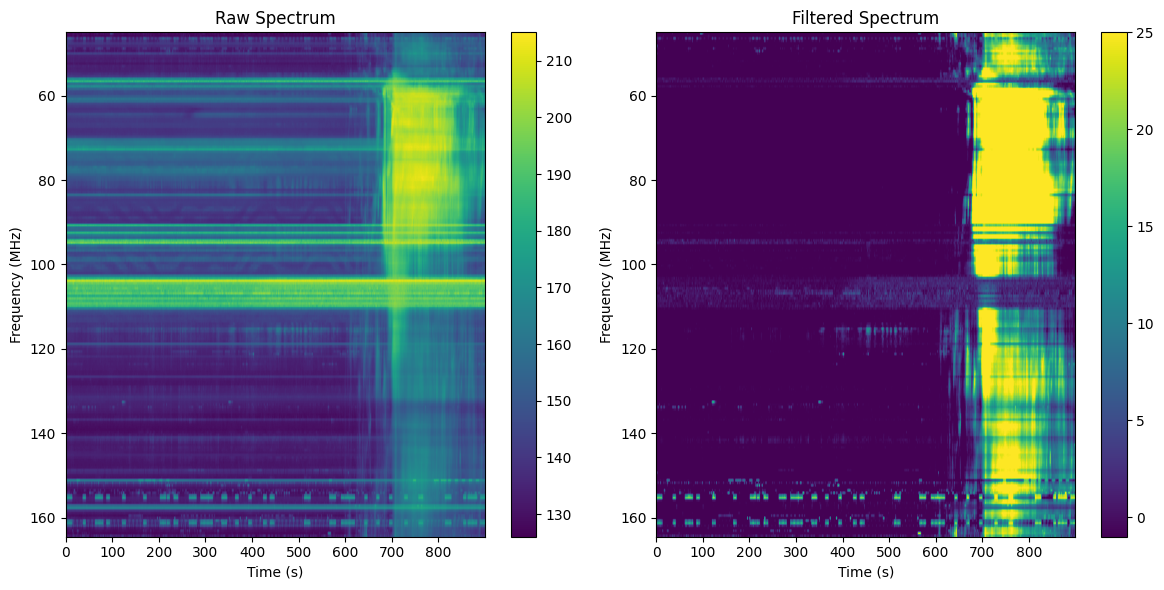

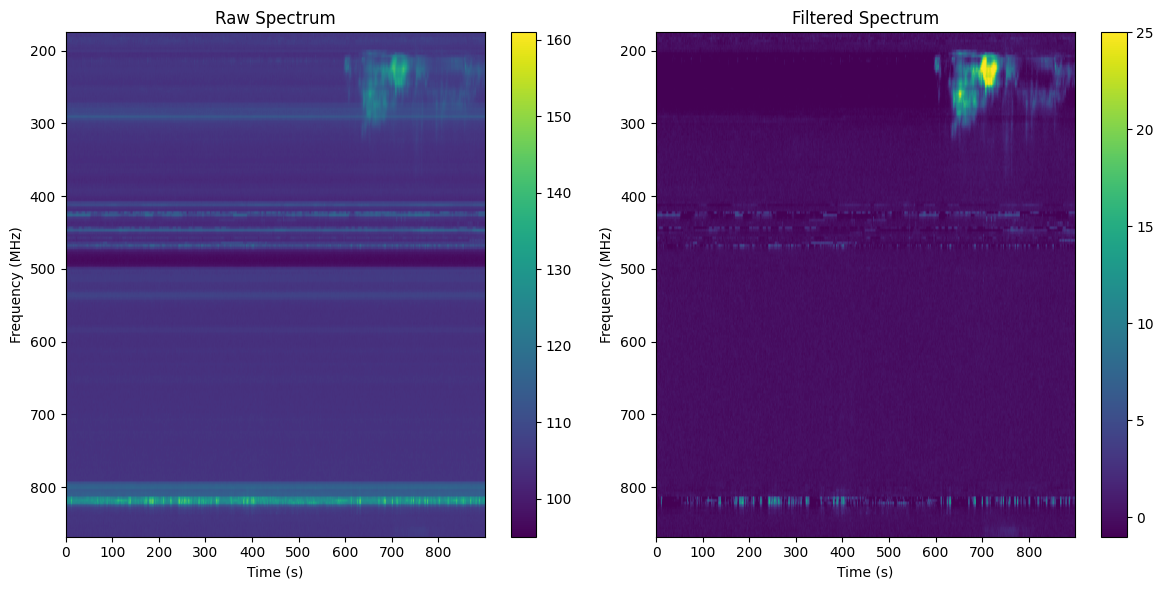

In [14]:
for i in range(3):
    plot_fits_data(dataset2[i], info2['freqs'][i], info2['times'][i])

In [18]:
dataset3, info3= read_fits_dataset('Type III radio burst 2022')
np.shape(dataset3)

100%|██████████| 520/520 [00:04<00:00, 128.52it/s]


(258, 200, 3600)

In [19]:
info3

,freqs,times,labels
0,"[92.93800354003906, 92.68800354003906, 92.4380...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",Type III
1,"[92.93800354003906, 92.68800354003906, 92.4380...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",Type III
2,"[92.93800354003906, 92.68800354003906, 92.4380...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",Type III
3,"[92.93800354003906, 92.68800354003906, 92.4380...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",Type III
4,"[92.93800354003906, 92.68800354003906, 92.4380...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",Type III
...,...,...,...
253,"[86.93800354003906, 86.5, 85.875, 85.75, 85.25...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",Type III
254,"[80.81300354003906, 80.68800354003906, 80.4380...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",Type III
255,"[80.81300354003906, 80.68800354003906, 80.4380...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",Type III
256,"[80.81300354003906, 80.68800354003906, 80.4380...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...",Type III


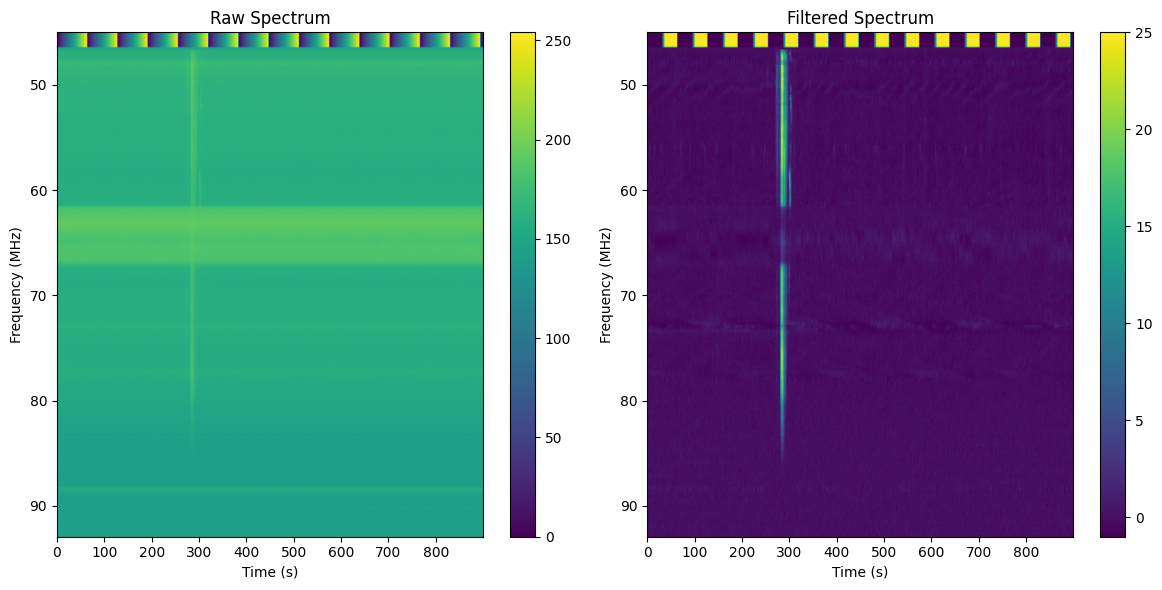

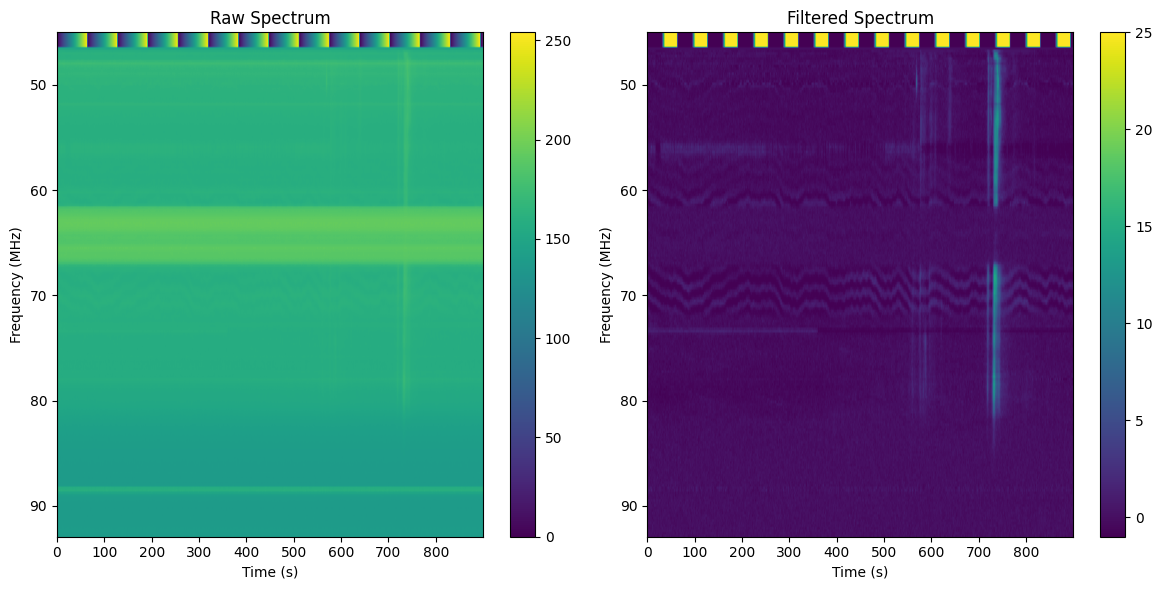

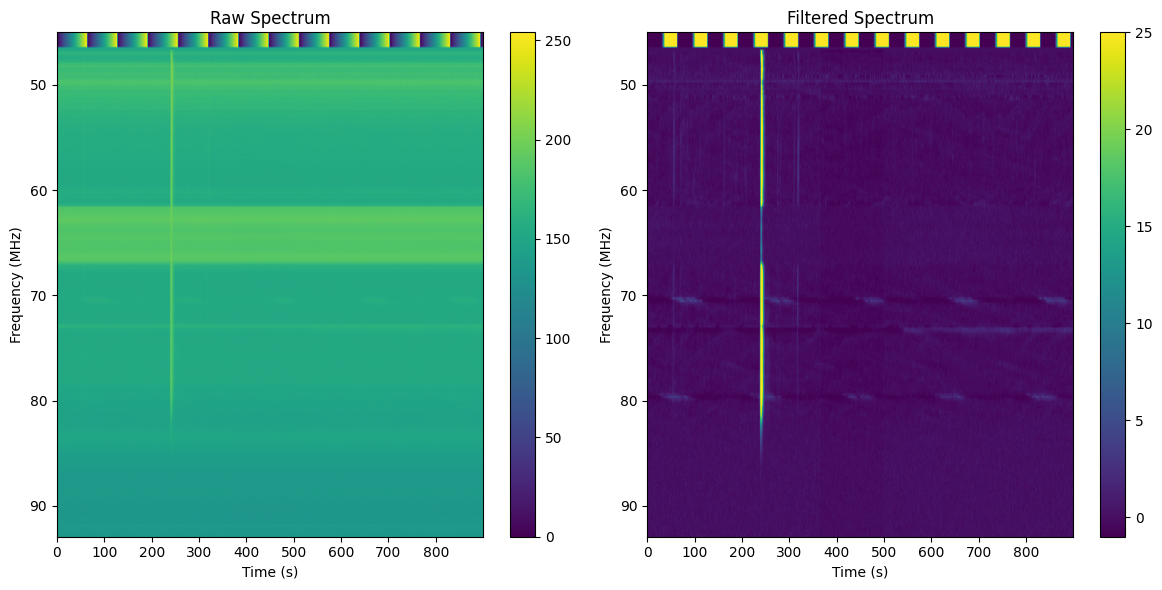

In [20]:
for i in range(3):
    plot_fits_data(dataset3[i], info3['freqs'][i], info3['times'][i])

In [23]:
print(f'the number of the samples for type II: {len(info2)}')
print(f'the number of the samples for type III: {len(info3)}')

the number of the samples for type II: 48
the number of the samples for type III: 258
